In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [12]:
raw = pd.read_csv(str(Path("../data/interim/integrated.csv")), 
                  parse_dates=True, infer_datetime_format=True, index_col=0)
raw_stats = raw.describe()
total = raw_stats.loc['count', 'Year']
raw_stats.loc['missing obs (%)'] = raw_stats.loc['count'].apply(lambda x : round((total-x) / total * 100,2))
missing_weather = raw['Weather'].isna().sum()
print("Observations missing in weather description column: " + str(round(missing_weather / total * 100,2)) + "%")
raw_stats

Observations missing in weather description column: 56.75%


,Year,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Visibility Flag,Stn Press (kPa),Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag
count,43824.000000,43824.000000,43824.000000,43803.000000,43802.000000,43797.000000,43780.000000,43801.000000,43805.000000,0.0,43803.000000,7340.000000,0.0,10124.000000,0.0
mean,2016.000000,6.523549,15.727820,9.071429,2.959212,67.758705,21.472567,16.422388,21.979384,NaN,99.553221,29.896866,NaN,-12.500494,NaN
std,1.413842,3.448572,8.799425,11.403631,10.814715,16.465946,10.096349,9.329768,5.332091,NaN,0.765471,3.741492,NaN,6.807851,NaN
min,2014.000000,1.000000,1.000000,-26.000000,-31.600000,13.000000,0.000000,0.000000,0.000000,NaN,96.490000,25.000000,NaN,-41.000000,NaN
25%,2015.000000,4.000000,8.000000,0.600000,-4.700000,56.000000,14.000000,9.000000,24.100000,NaN,99.070000,27.000000,NaN,-17.000000,NaN
50%,2016.000000,7.000000,16.000000,9.300000,3.300000,69.000000,24.000000,15.000000,24.100000,NaN,99.570000,29.000000,NaN,-11.000000,NaN
75%,2017.000000,10.000000,23.000000,18.700000,12.000000,80.000000,30.000000,22.000000,24.100000,NaN,100.050000,32.000000,NaN,-7.000000,NaN
max,2018.000000,12.000000,31.000000,35.200000,25.000000,99.000000,36.000000,80.000000,80.500000,NaN,102.210000,46.000000,NaN,0.000000,NaN
missing obs (%),0.000000,0.000000,0.000000,0.050000,0.050000,0.060000,0.100000,0.050000,0.040000,100.0,0.050000,83.250000,100.0,76.900000,100.0


In [7]:
# Select columns that are meaningful: 
# - For analysis, drop redundant time columns
# - Ignore flag columns as they contain no data
# - Discard Hmdx, Wind Chill, and Weather due to sparseness of data.
select = raw.iloc[:,[4,6,8,10,12,14,16]]

In [8]:
stats = select.describe()
stats.loc['IQR'] = (stats.loc['75%'] - stats.loc['25%'])
stats.loc['low'] = stats.loc['25%'] - (1.5 * stats.loc['IQR'])
stats.loc['high'] = stats.loc['75%'] + (1.5 * stats.loc['IQR'])
stats.loc['missing'] = select.isna().sum()
stats

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa)
count,43803.000000,43802.000000,43797.000000,43780.000000,43801.000000,43805.000000,43803.000000
mean,9.071429,2.959212,67.758705,21.472567,16.422388,21.979384,99.553221
std,11.403631,10.814715,16.465946,10.096349,9.329768,5.332091,0.765471
min,-26.000000,-31.600000,13.000000,0.000000,0.000000,0.000000,96.490000
25%,0.600000,-4.700000,56.000000,14.000000,9.000000,24.100000,99.070000
50%,9.300000,3.300000,69.000000,24.000000,15.000000,24.100000,99.570000
75%,18.700000,12.000000,80.000000,30.000000,22.000000,24.100000,100.050000
max,35.200000,25.000000,99.000000,36.000000,80.000000,80.500000,102.210000
IQR,18.100000,16.700000,24.000000,16.000000,13.000000,0.000000,0.980000
low,-26.550000,-29.750000,20.000000,-10.000000,-10.500000,24.100000,97.600000


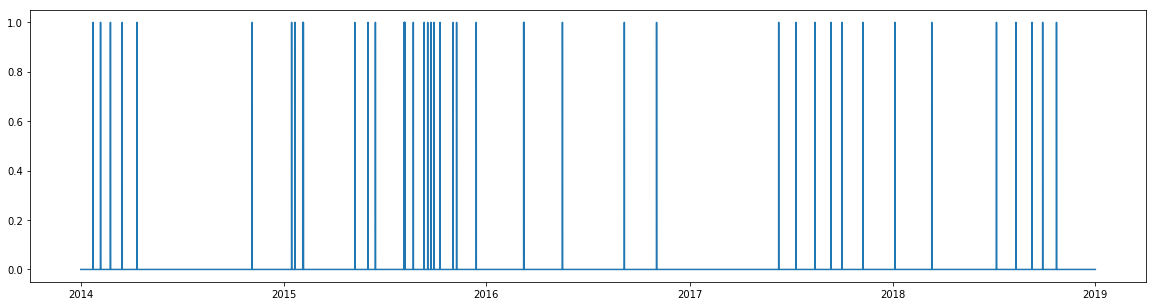

In [9]:
# Look at rows with missing values
plt.subplots(figsize=(20,5))
plt.plot(select.isnull().any(axis=1).map(int))
plt.show()

In [10]:
# How to deal with missing data: persist? interpolate? average? regression?
clean_persist = select.fillna(method='ffill').fillna(method='bfill')
clean_interpolate = select.interpolate(method='linear', limit_direction='both')
clean_mean = select.fillna(stats.loc['mean'], axis=0)
clean = clean_persist

# To properly evaluate methods, try removing random values from the data, doing various data imputation methods,
# and calculating MSE against original data

#print("Persistence method MSE = " + str(error_persist))
#print("Interpolation method MSE = " + str(error_interpolate))
#print("Mean method MSE = " + str(error_mean))